# Team members
- Bryce Grahn
- Michael Rolle
- Werner de jager
- Abdul Gany Osman
- Lavania Naidoo

# Introduction
The aim of this notebook is undertaking a machine learning investigation on the....

# 1. Imports and installations

In [1]:
#PIP
# update plotly and pandas_profiling version
!pip install --upgrade plotly
!pip install sweetviz
!pip install autoviz

#jkdnfkad

# imports
import os
import math
import numpy as np
import scipy as sp
import pandas as pd
import sympy as sym
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import sweetviz as sw

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.linear_model import LinearRegression, SGDRegressor, SGDClassifier, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from itertools import chain
from scipy.stats.mstats import winsorize

# define plt settings 
plt.rcParams["font.size"] = 20 
plt.rcParams["axes.labelsize"] = 20 
plt.rcParams["xtick.labelsize"] = 20 
plt.rcParams["ytick.labelsize"] = 20 
plt.rcParams["legend.fontsize"] = 20 
plt.rcParams["figure.figsize"] = (20,10)

# define seaborn settings seaborn
sns.set(style="ticks", color_codes=True)
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.22.0
    Uninstalling plotly-5.22.0:
      Successfully uninstalled plotly-5.22.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.0/161.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nlt

## 1.1 Import Dataset

In [2]:
import os
os.listdir("/kaggle/input/payments-hackathon-rojones/Payments Fraud DataSet/")

['transactions_test.csv',
 'transactions_train.csv',
 'terminals.csv',
 'merchants.csv',
 'customers.csv']

In [3]:
url = '/kaggle/input/payments-hackathon-rojones/Payments Fraud DataSet/'

customers_df = pd.read_csv(url + "customers.csv", index_col = 'CUSTOMER_ID')
terminals_df = pd.read_csv(url + "terminals.csv", index_col = 'TERMINAL_ID')
merchants_df = pd.read_csv(url + "merchants.csv", index_col = 'MERCHANT_ID')
transactions_test_df = pd.read_csv(url + "transactions_test.csv", index_col = 'TX_ID')
transactions_train_df = pd.read_csv(url + "transactions_test.csv", index_col = 'TX_ID')

## 1.2 Display datasets

In [4]:
print("Customers dataset:")
print("----------------------")
display(customers_df.info())
print("\nterminals dataset:")
print("----------------------")
display(terminals_df.info())
print("\nmerchants dataset:")
print("----------------------")
display(merchants_df.info())
print("\ntransactions_test dataset:")
print("----------------------")
display(transactions_test_df.info())
print("\ntransactions_train dataset:")
print("----------------------")
display(transactions_train_df.info())

Customers dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 7894622031164826 to 5987355644780185
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x_customer_id  50000 non-null  float64
 1   y_customer_id  50000 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


None


terminals dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 9754224 to 14982407
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x_terminal_id   5000 non-null   float64
 1   y_terminal__id  5000 non-null   float64
dtypes: float64(2)
memory usage: 117.2 KB


None


merchants dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 30452 entries, 1b7557bb-208b-4fdc-ba91-eca98298541a to cb5826ba-6a40-4f7f-9b53-ae7f3e35e740
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   BUSINESS_TYPE                       30452 non-null  object
 1   MCC_CODE                            30452 non-null  int64 
 2   LEGAL_NAME                          30452 non-null  object
 3   FOUNDATION_DATE                     30452 non-null  object
 4   TAX_EXCEMPT_INDICATOR               30452 non-null  bool  
 5   OUTLET_TYPE                         30452 non-null  object
 6   ACTIVE_FROM                         30452 non-null  object
 7   TRADING_FROM                        30452 non-null  object
 8   ANNUAL_TURNOVER_CARD                30452 non-null  int64 
 9   ANNUAL_TURNOVER                     30452 non-null  int64 
 10  AVERAGE_TICKET

None


transactions_test dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 71139 entries, 09324d812ba7915c3f791e973db293ad50db70d8 to 4af7a6f698e30cecc97ac5254315c97db971bf56
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   TX_TS                                  71139 non-null  object 
 1   CUSTOMER_ID                            71139 non-null  int64  
 2   TERMINAL_ID                            71139 non-null  int64  
 3   TX_AMOUNT                              71139 non-null  float64
 4   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  71139 non-null  float64
 5   TRANSACTION_CASHBACK_AMOUNT            71139 non-null  float64
 6   CARD_EXPIRY_DATE                       71139 non-null  object 
 7   CARD_DATA                              71139 non-null  object 
 8   CARD_BRAND                             71139 non-null  object 
 9   TRANSACTION_TYPE  

None


transactions_train dataset:
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 71139 entries, 09324d812ba7915c3f791e973db293ad50db70d8 to 4af7a6f698e30cecc97ac5254315c97db971bf56
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   TX_TS                                  71139 non-null  object 
 1   CUSTOMER_ID                            71139 non-null  int64  
 2   TERMINAL_ID                            71139 non-null  int64  
 3   TX_AMOUNT                              71139 non-null  float64
 4   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  71139 non-null  float64
 5   TRANSACTION_CASHBACK_AMOUNT            71139 non-null  float64
 6   CARD_EXPIRY_DATE                       71139 non-null  object 
 7   CARD_DATA                              71139 non-null  object 
 8   CARD_BRAND                             71139 non-null  object 
 9   TRANSACTION_TYPE 

None

## 1.3 Table heads


In [5]:
print("Customers dataset:")
print("----------------------")
display(customers_df.head())
print("\nterminals dataset:")
print("----------------------")
display(terminals_df.head())
print("\nmerchants dataset:")
print("----------------------")
display(merchants_df.head())
print("\ntransactions_test dataset:")
print("----------------------")
display(transactions_test_df.head())
print("\ntransactions_train dataset:")
print("----------------------")
display(transactions_train_df.head())

Customers dataset:
----------------------


,x_customer_id,y_customer_id
CUSTOMER_ID,,
7894622031164826,7.600289,92.486016
65009550197454,97.647808,36.539666
5381378528001886,98.643812,46.537793
344044685095332,2.814298,57.194127
5281794686066290,49.174496,88.879290



terminals dataset:
----------------------


,x_terminal_id,y_terminal__id
TERMINAL_ID,,
9754224,41.536730,68.889911
37467861,61.864075,20.882662
20678215,70.530677,36.567633
12724021,92.961874,66.721471
2989793,38.756717,68.669003



merchants dataset:
----------------------


,BUSINESS_TYPE,MCC_CODE,LEGAL_NAME,FOUNDATION_DATE,TAX_EXCEMPT_INDICATOR,OUTLET_TYPE,ACTIVE_FROM,TRADING_FROM,ANNUAL_TURNOVER_CARD,ANNUAL_TURNOVER,AVERAGE_TICKET_SALE_AMOUNT,PAYMENT_PERCENTAGE_FACE_TO_FACE,PAYMENT_PERCENTAGE_ECOM,PAYMENT_PERCENTAGE_MOTO,DEPOSIT_REQUIRED_PERCENTAGE,DEPOSIT_PERCENTAGE,DELIVERY_SAME_DAYS_PERCENTAGE,DELIVERY_WEEK_ONE_PERCENTAGE,DELIVERY_WEEK_TWO_PERCENTAGE,DELIVERY_OVER_TWO_WEEKS_PERCENTAGE
MERCHANT_ID,,,,,,,,,,,,,,,,,,,,
1b7557bb-208b-4fdc-ba91-eca98298541a,Corporations,1711,14b61a,2012-01-11,False,Ecommerce,2012-02-02,2012-02-06,197030527,351840227,550,49,51,0,0,0,26,25,28,21
6c948718-ea18-4d07-85d7-0916eb55e699,Corporations,5511,05047b,2013-03-17,False,Ecommerce,2013-04-06,2013-04-12,411017547,411017547,36326,50,50,0,0,0,22,28,25,25
f0151a49-7ac0-4258-93db-46bee2db6f66,Corporations,5971,e3c9e5,2019-03-03,False,Ecommerce,2019-03-06,2019-03-15,196408214,306887834,546,54,46,0,0,0,29,28,23,20
07089d03-0d63-4d24-a3f9-e651fda07cdc,Corporations,7629,940e26,2011-05-31,False,Ecommerce,2011-06-23,2011-07-03,603864188,686209305,657,57,43,0,0,0,22,27,26,25
2c16629a-da48-4e69-9862-8fd521a53bbc,Corporations,8398,bd9404,2019-03-26,False,Ecommerce,2019-04-14,2019-04-23,384701644,384701644,541,62,33,5,0,0,24,20,26,30



transactions_test dataset:
----------------------


,TX_TS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_EXPIRY_DATE,CARD_DATA,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,FAILURE_CODE,FAILURE_REASON,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,MERCHANT_ID,IS_RECURRING_TRANSACTION,ACQUIRER_ID,CARDHOLDER_AUTH_METHOD,ID_JOIN
TX_ID,,,,,,,,,,,,,,,,,,,,
09324d812ba7915c3f791e973db293ad50db70d8,2021-12-03 22:04:58+00:00,4635360198955981,4641801,34.61,34.61,0.0,05/23,3409********496,AMEX,Purchase,Settled,NaN,NaN,USD,US,52f53dfb-6f2c-4584-8c82-aeafbcd7a02d,False,ACQ2,Signature,5637.0
a17bc798bacadbde6cd7928688e2453fa6023d67,2021-12-03 05:32:09+00:00,3695434572951846,75652463,39.74,39.74,0.0,12/22,3407********567,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ebd8abbf-db80-4ac2-a83b-6b3642f7140a,False,ACQ3,Signature,16253.0
dee3efed3600425f60eee0e9d363f9bac226e12a,2021-12-02 07:22:50+00:00,2021639056384826,45740229,15.60,15.60,0.0,10/23,3777********873,AMEX,Purchase,Settled,NaN,NaN,USD,FI,faffd1ae-c962-4a11-b664-2ce691c23df8,False,ACQ3,Signature,20501.0
e0b665434d7945d6b170eb8da1b88d3fdfaaf3f7,2021-12-03 06:00:31+00:00,5182312031642618,12372906,62.81,62.81,0.0,08/22,3427********736,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ef16b77c-1595-4af7-9a50-a0b9f8507bbf,False,ACQ3,Signature,450.0
b25981de8b5dcdc1c38de111a21312115c34199d,2021-12-04 17:52:16+00:00,2904034201365313,61785600,71.00,71.00,0.0,12/23,3427********913,AMEX,Purchase,Settled,NaN,NaN,USD,CA,b62e5e95-63fa-4fa8-b3d2-3eb03616208a,False,ACQ1,Signature,24900.0



transactions_train dataset:
----------------------


,TX_TS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_EXPIRY_DATE,CARD_DATA,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,FAILURE_CODE,FAILURE_REASON,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,MERCHANT_ID,IS_RECURRING_TRANSACTION,ACQUIRER_ID,CARDHOLDER_AUTH_METHOD,ID_JOIN
TX_ID,,,,,,,,,,,,,,,,,,,,
09324d812ba7915c3f791e973db293ad50db70d8,2021-12-03 22:04:58+00:00,4635360198955981,4641801,34.61,34.61,0.0,05/23,3409********496,AMEX,Purchase,Settled,NaN,NaN,USD,US,52f53dfb-6f2c-4584-8c82-aeafbcd7a02d,False,ACQ2,Signature,5637.0
a17bc798bacadbde6cd7928688e2453fa6023d67,2021-12-03 05:32:09+00:00,3695434572951846,75652463,39.74,39.74,0.0,12/22,3407********567,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ebd8abbf-db80-4ac2-a83b-6b3642f7140a,False,ACQ3,Signature,16253.0
dee3efed3600425f60eee0e9d363f9bac226e12a,2021-12-02 07:22:50+00:00,2021639056384826,45740229,15.60,15.60,0.0,10/23,3777********873,AMEX,Purchase,Settled,NaN,NaN,USD,FI,faffd1ae-c962-4a11-b664-2ce691c23df8,False,ACQ3,Signature,20501.0
e0b665434d7945d6b170eb8da1b88d3fdfaaf3f7,2021-12-03 06:00:31+00:00,5182312031642618,12372906,62.81,62.81,0.0,08/22,3427********736,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ef16b77c-1595-4af7-9a50-a0b9f8507bbf,False,ACQ3,Signature,450.0
b25981de8b5dcdc1c38de111a21312115c34199d,2021-12-04 17:52:16+00:00,2904034201365313,61785600,71.00,71.00,0.0,12/23,3427********913,AMEX,Purchase,Settled,NaN,NaN,USD,CA,b62e5e95-63fa-4fa8-b3d2-3eb03616208a,False,ACQ1,Signature,24900.0


In [6]:
transactions_train_df.head(1000)


,TX_TS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TRANSACTION_GOODS_AND_SERVICES_AMOUNT,TRANSACTION_CASHBACK_AMOUNT,CARD_EXPIRY_DATE,CARD_DATA,CARD_BRAND,TRANSACTION_TYPE,TRANSACTION_STATUS,FAILURE_CODE,FAILURE_REASON,TRANSACTION_CURRENCY,CARD_COUNTRY_CODE,MERCHANT_ID,IS_RECURRING_TRANSACTION,ACQUIRER_ID,CARDHOLDER_AUTH_METHOD,ID_JOIN
TX_ID,,,,,,,,,,,,,,,,,,,,
09324d812ba7915c3f791e973db293ad50db70d8,2021-12-03 22:04:58+00:00,4635360198955981,4641801,34.61,34.61,0.0,05/23,3409********496,AMEX,Purchase,Settled,NaN,NaN,USD,US,52f53dfb-6f2c-4584-8c82-aeafbcd7a02d,False,ACQ2,Signature,5637.0
a17bc798bacadbde6cd7928688e2453fa6023d67,2021-12-03 05:32:09+00:00,3695434572951846,75652463,39.74,39.74,0.0,12/22,3407********567,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ebd8abbf-db80-4ac2-a83b-6b3642f7140a,False,ACQ3,Signature,16253.0
dee3efed3600425f60eee0e9d363f9bac226e12a,2021-12-02 07:22:50+00:00,2021639056384826,45740229,15.60,15.60,0.0,10/23,3777********873,AMEX,Purchase,Settled,NaN,NaN,USD,FI,faffd1ae-c962-4a11-b664-2ce691c23df8,False,ACQ3,Signature,20501.0
e0b665434d7945d6b170eb8da1b88d3fdfaaf3f7,2021-12-03 06:00:31+00:00,5182312031642618,12372906,62.81,62.81,0.0,08/22,3427********736,AMEX,Purchase,Settled,NaN,NaN,CNY,US,ef16b77c-1595-4af7-9a50-a0b9f8507bbf,False,ACQ3,Signature,450.0
b25981de8b5dcdc1c38de111a21312115c34199d,2021-12-04 17:52:16+00:00,2904034201365313,61785600,71.00,71.00,0.0,12/23,3427********913,AMEX,Purchase,Settled,NaN,NaN,USD,CA,b62e5e95-63fa-4fa8-b3d2-3eb03616208a,False,ACQ1,Signature,24900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92ac303415e35c233d18a179eed72d982e9881d0,2021-12-03 20:06:48+00:00,4743579660939532,26743301,20.91,20.91,0.0,08/22,3777********690,AMEX,Purchase,Settled,NaN,NaN,GBP,GB,0e7aeb5f-d0bf-4ae9-a00e-77fc88278aa2,False,ACQ3,Online PIN,18511.0
e0d298578918f6b7206a8180842b0b9bf15a4004,2021-12-02 02:34:44+00:00,7382786687405234,99390560,114.90,114.90,0.0,10/23,3777********344,AMEX,Purchase,Settled,NaN,NaN,JPY,US,f73c7776-4945-4b76-9c1f-0a38a62b5e4b,False,ACQ3,Online PIN,16816.0
14b65b24fcc857a91a489c1df8f9be3c9faf3b50,2021-12-03 21:38:13+00:00,1638688263444189,42111837,34.22,34.22,0.0,03/23,3742********722,AMEX,Purchase,Settled,NaN,NaN,USD,US,a47be87a-268a-4d6a-bca8-bdea3cb3a6c1,False,ACQ3,Online PIN,5326.0


# 2. Data visualization and analysis

                                             |          | [  0%]   00:00 -> (? left)


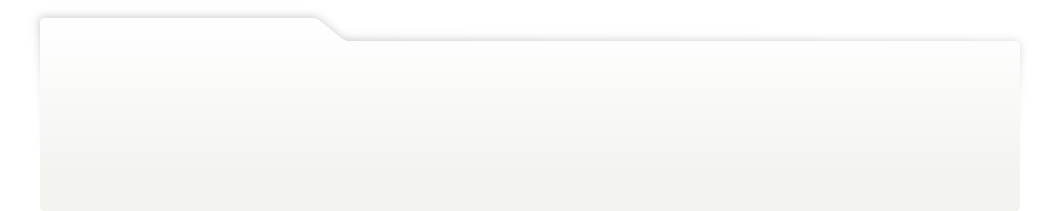
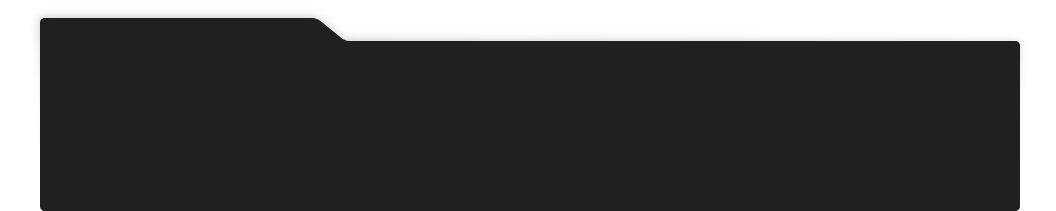
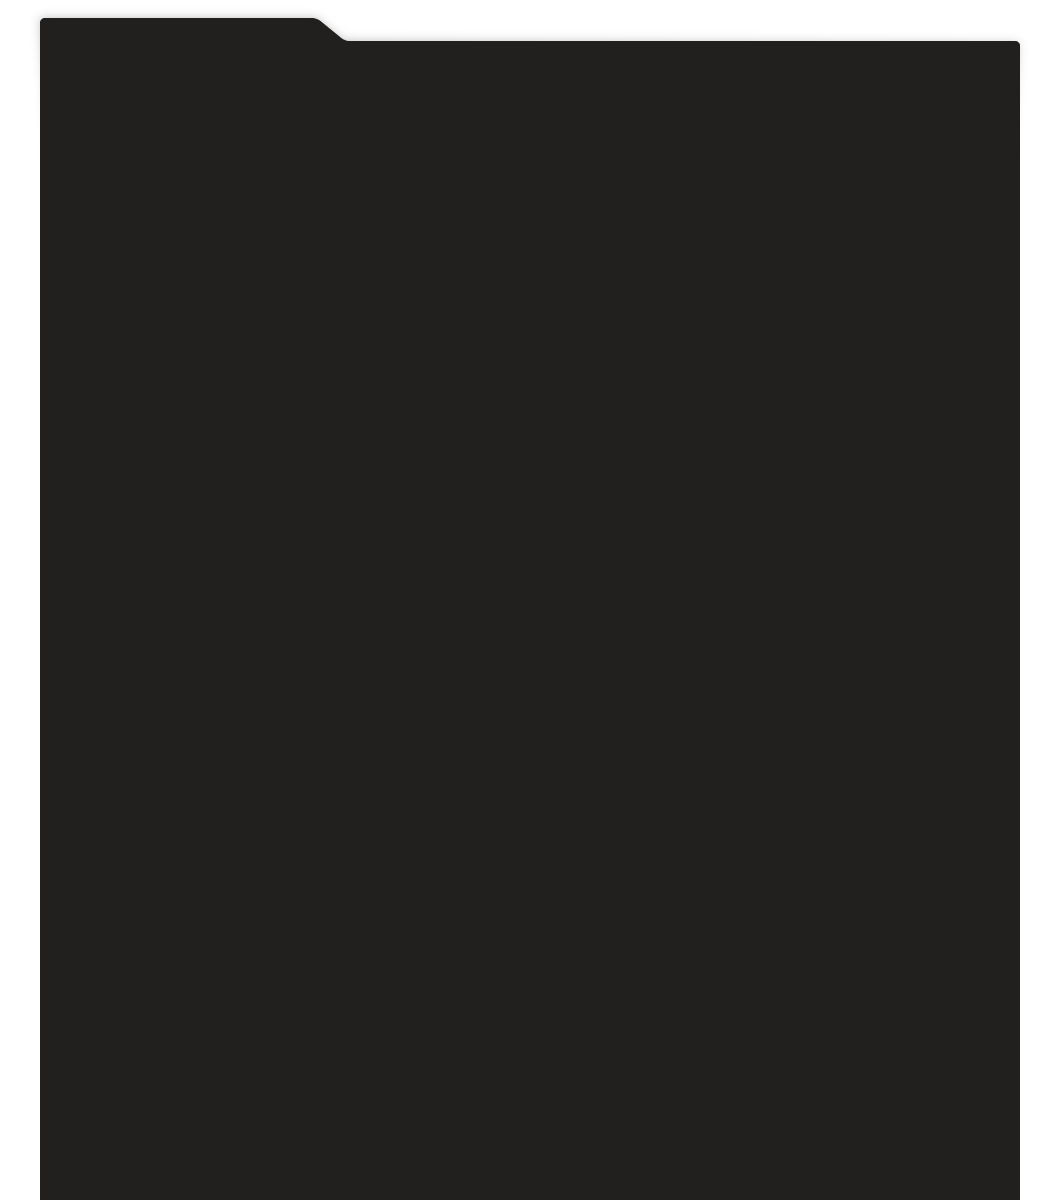
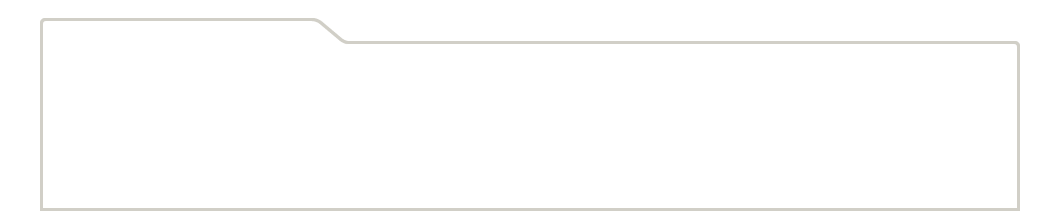
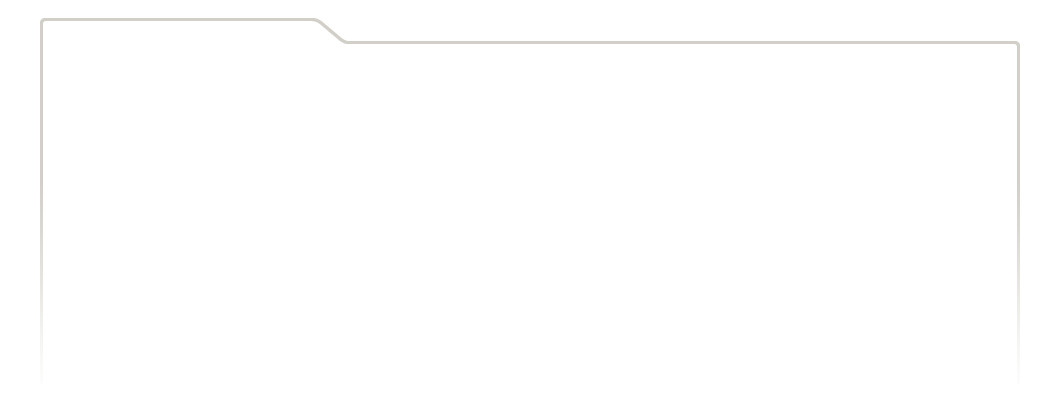
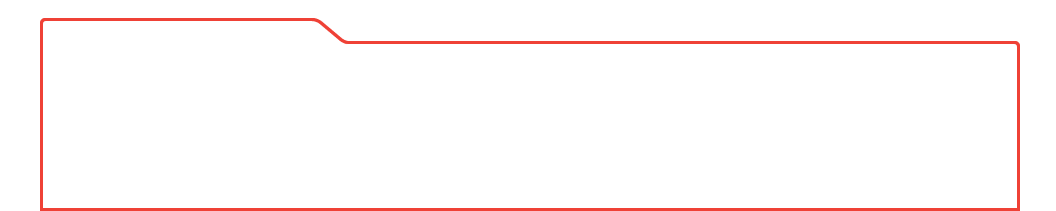
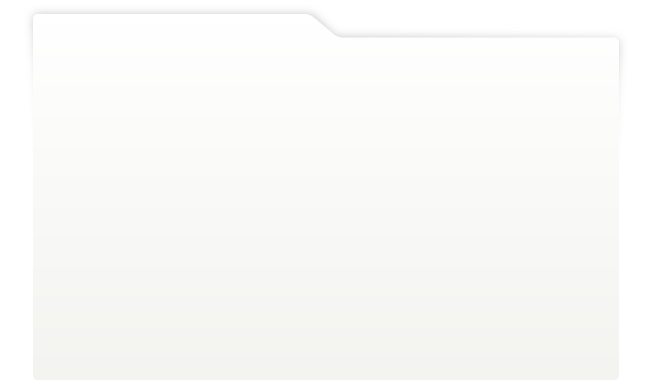
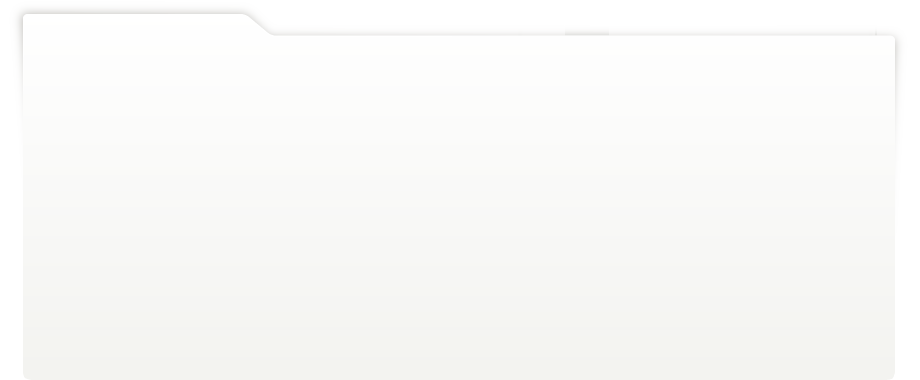
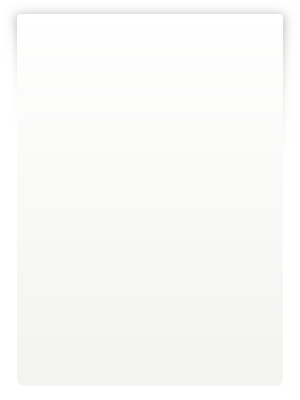
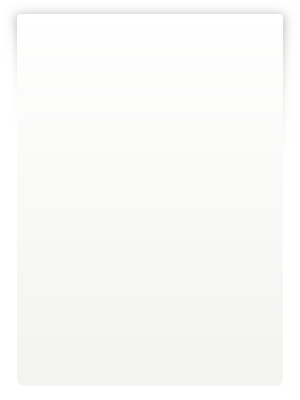
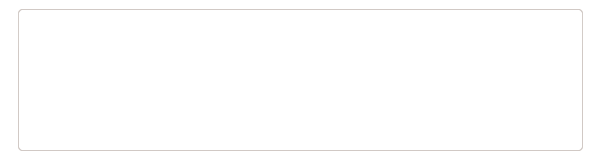
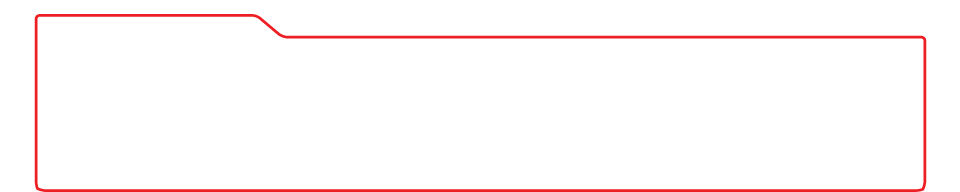
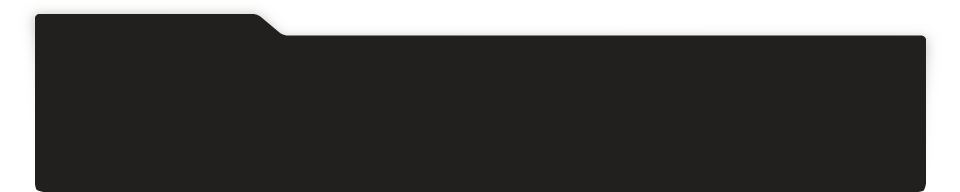
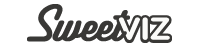
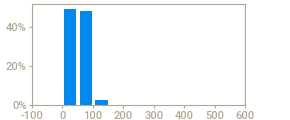
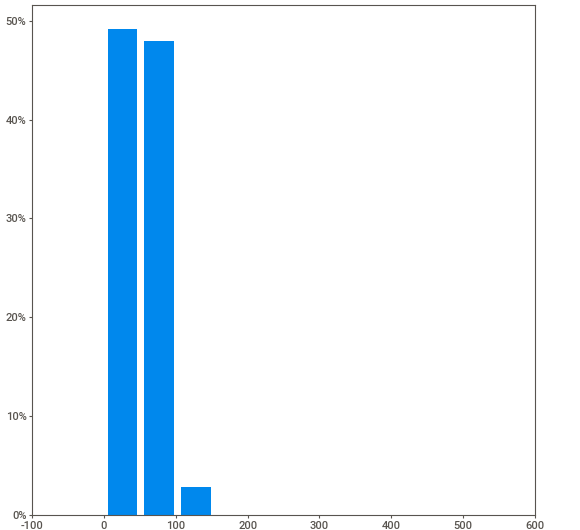
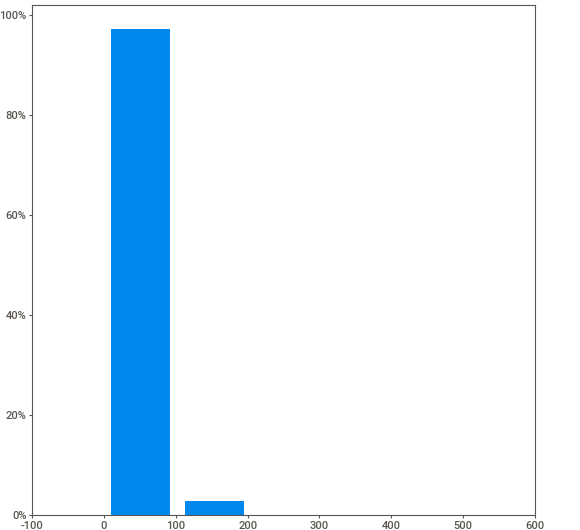
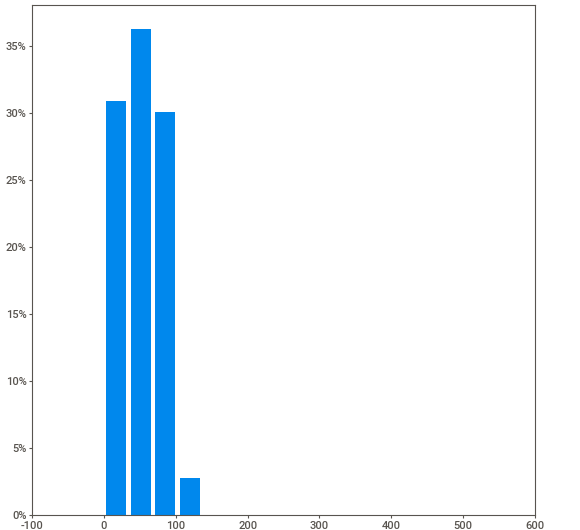
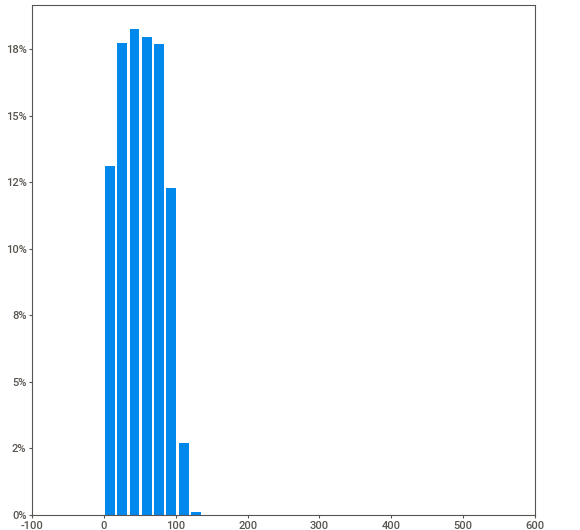
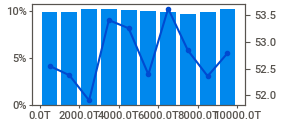
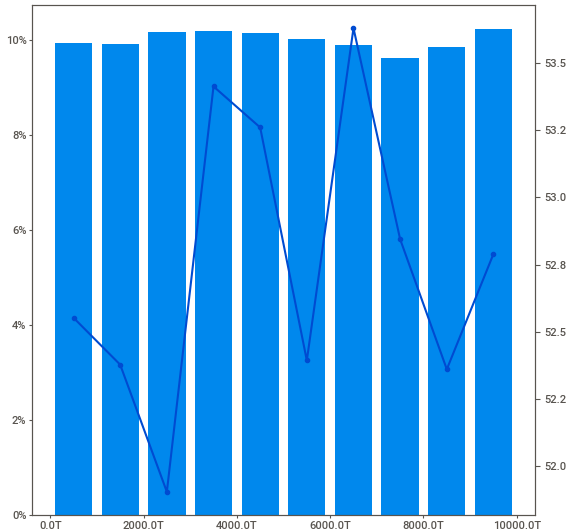
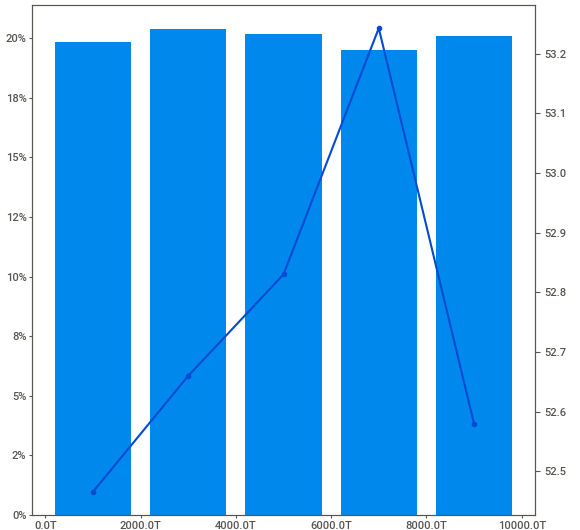
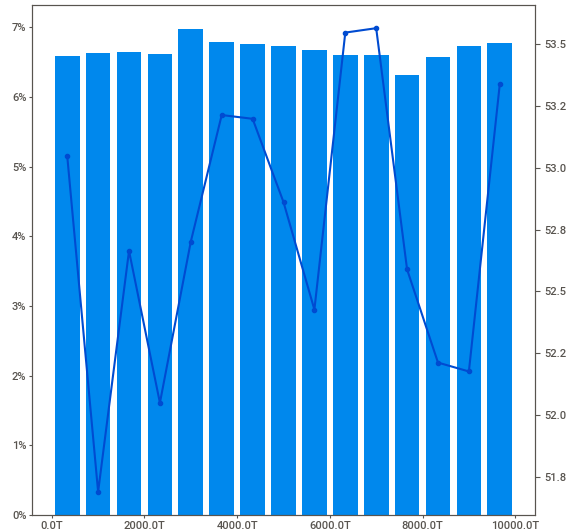
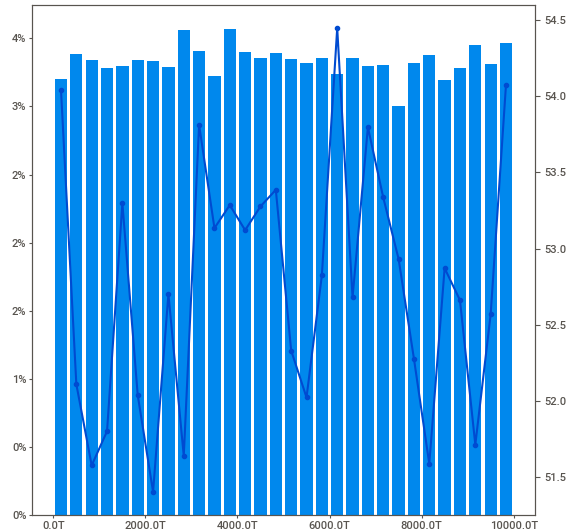
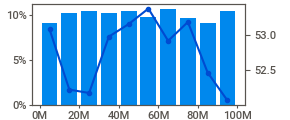
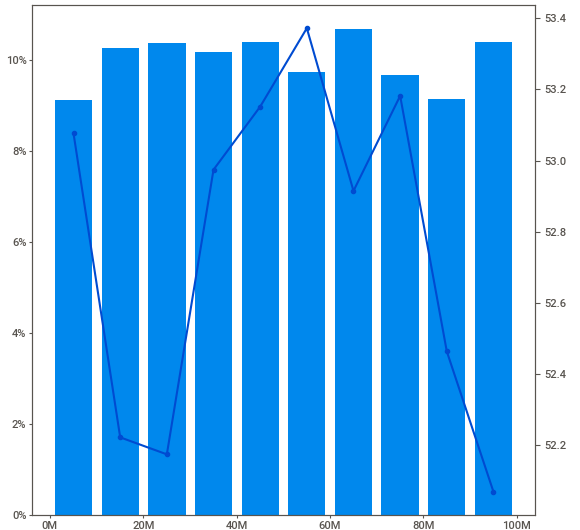
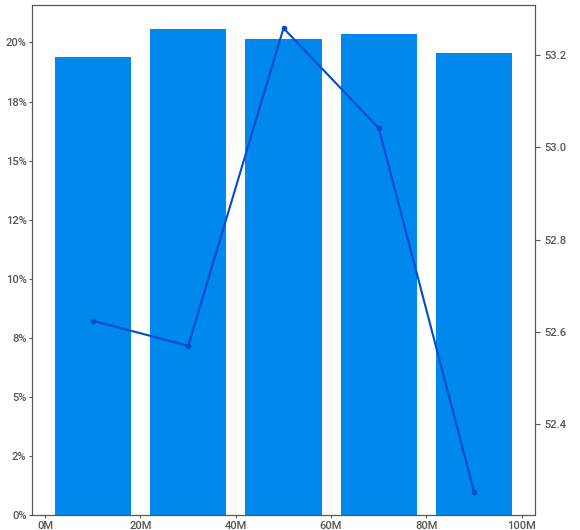
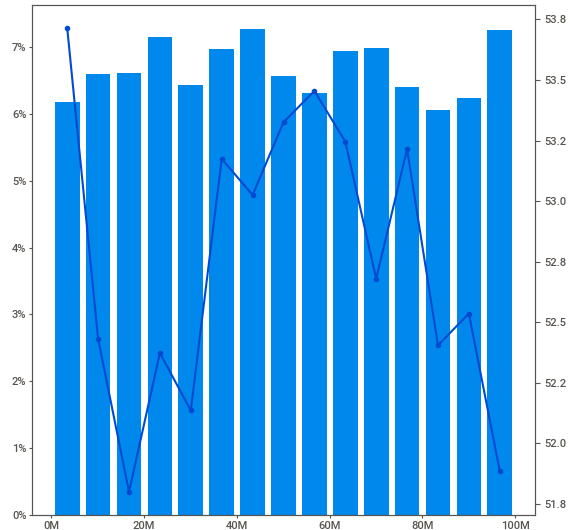
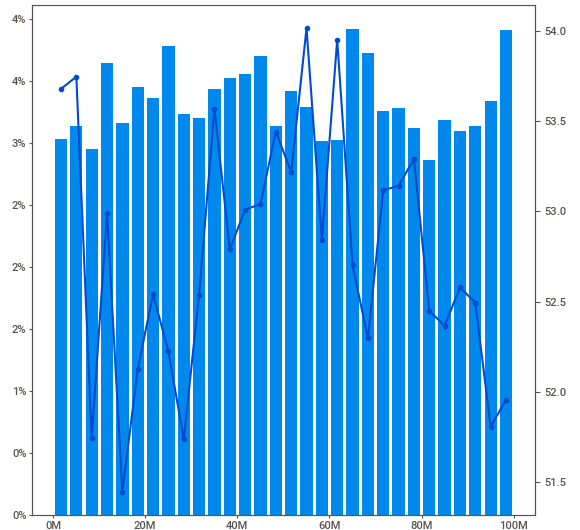
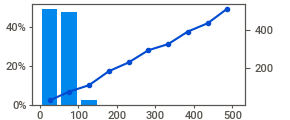
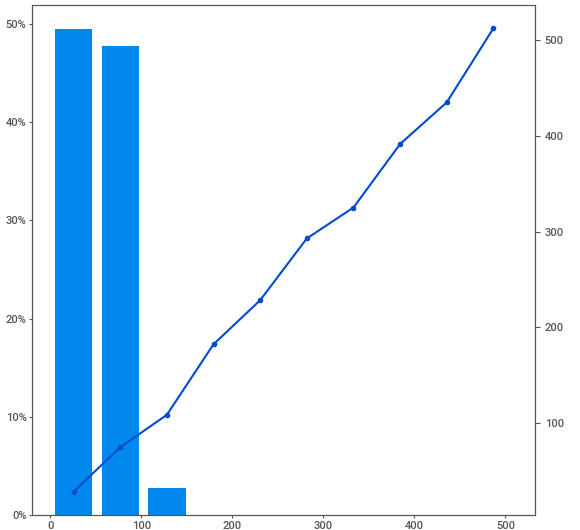
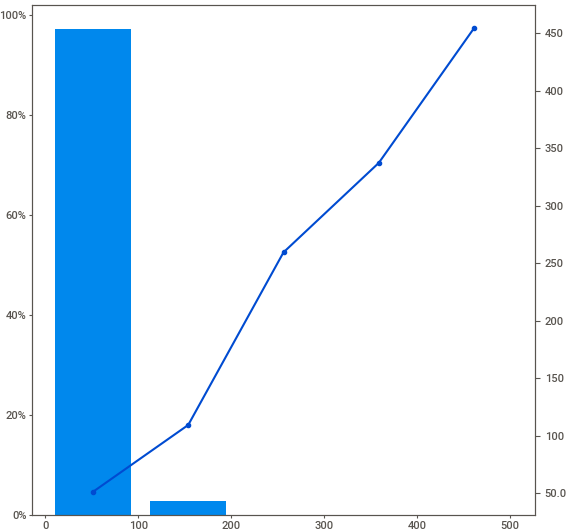
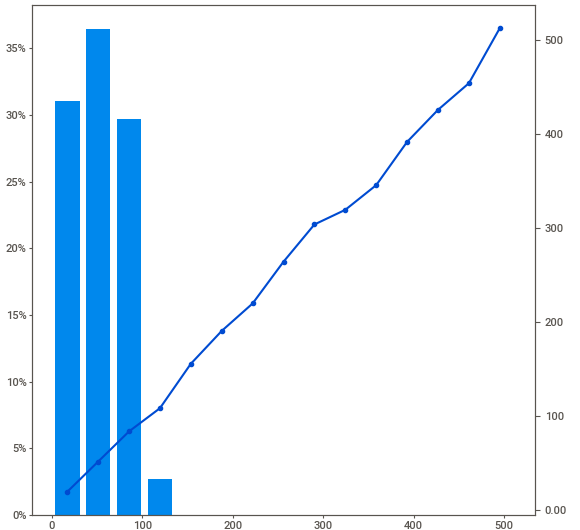
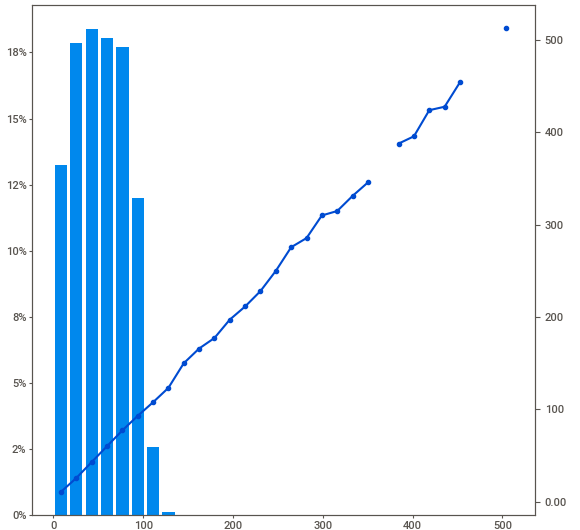
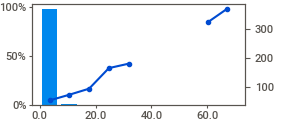
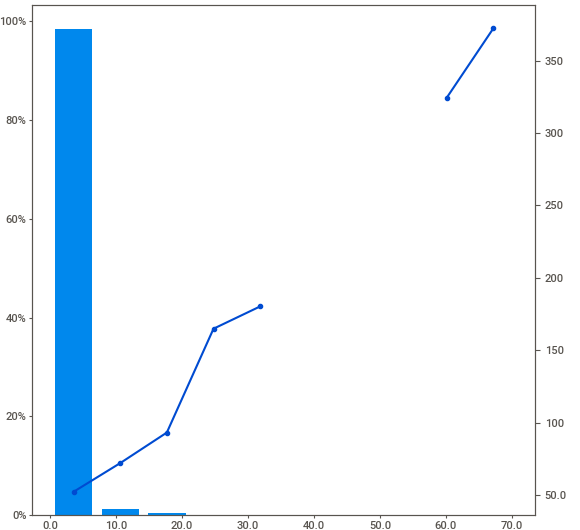
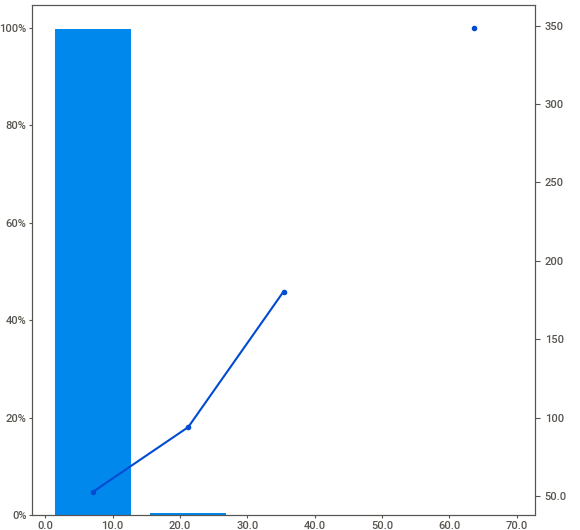
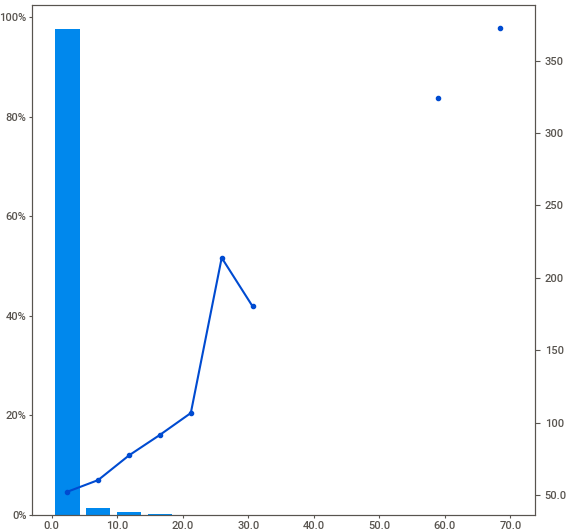
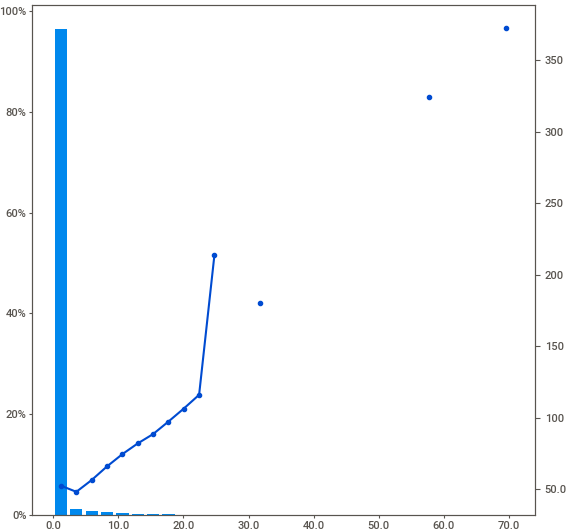
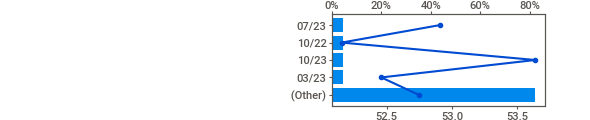
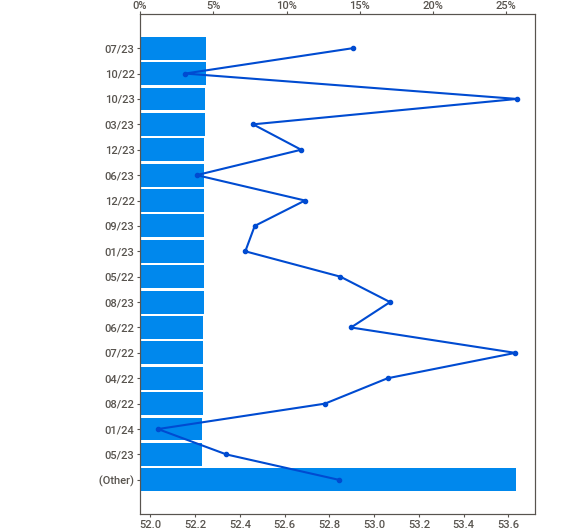
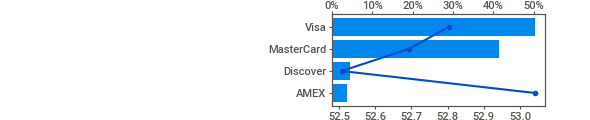
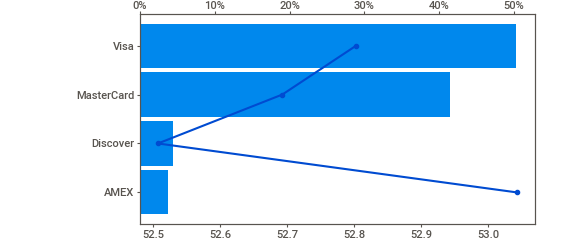
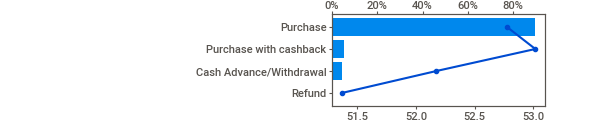
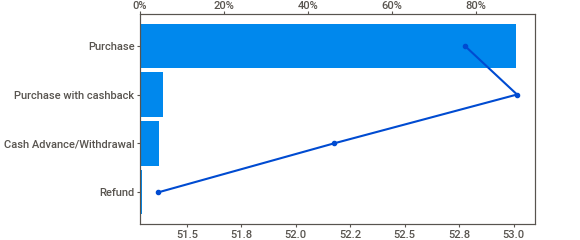
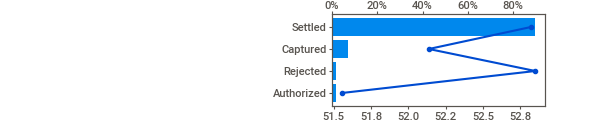
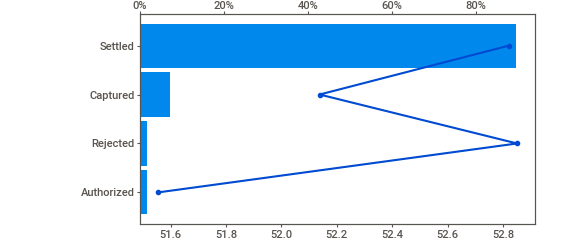
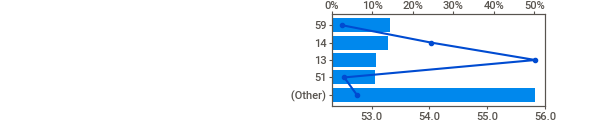
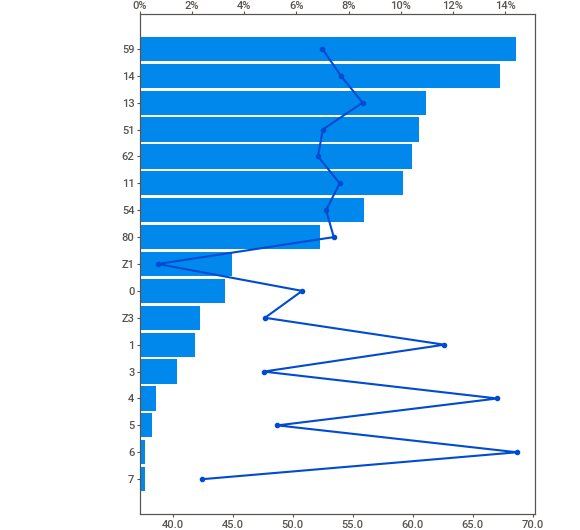
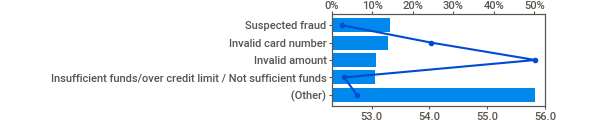
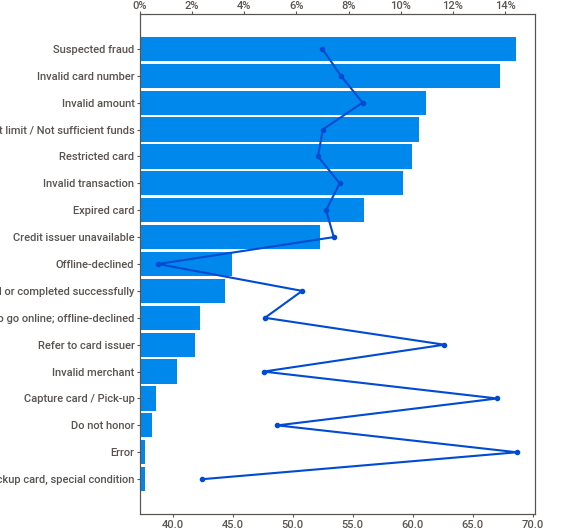
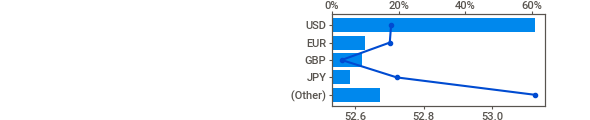
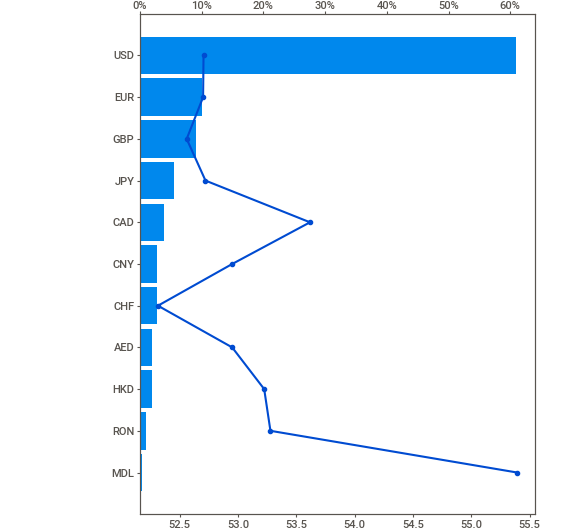
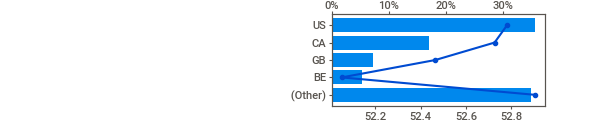
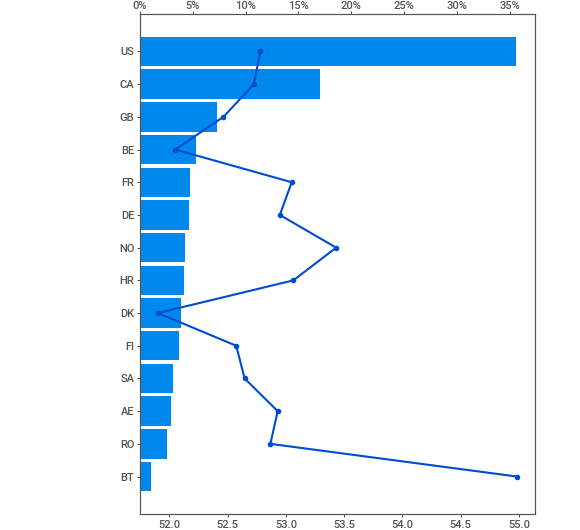
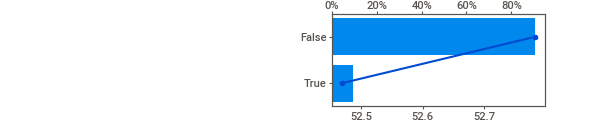
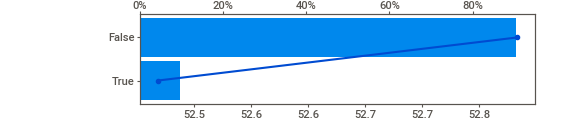
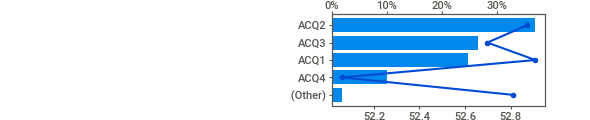
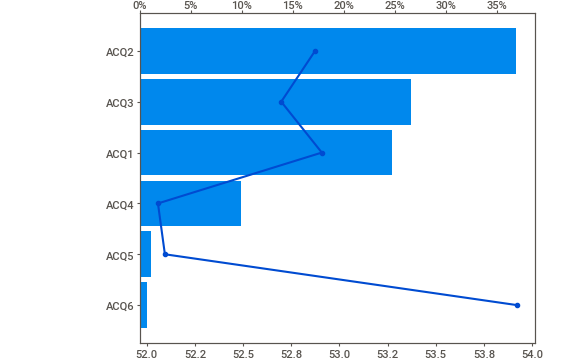
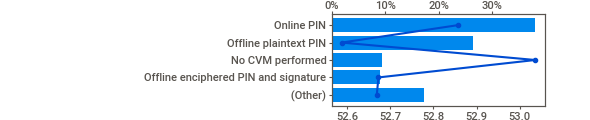
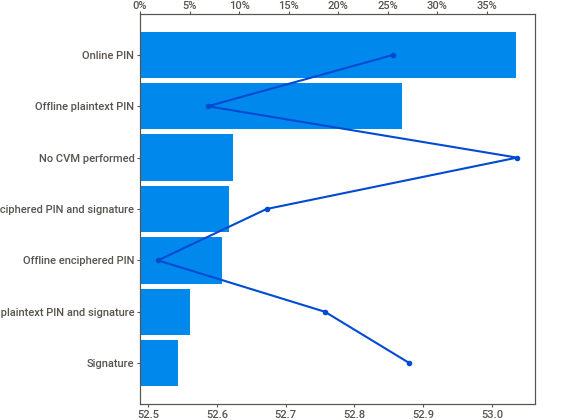
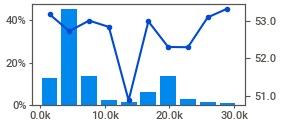
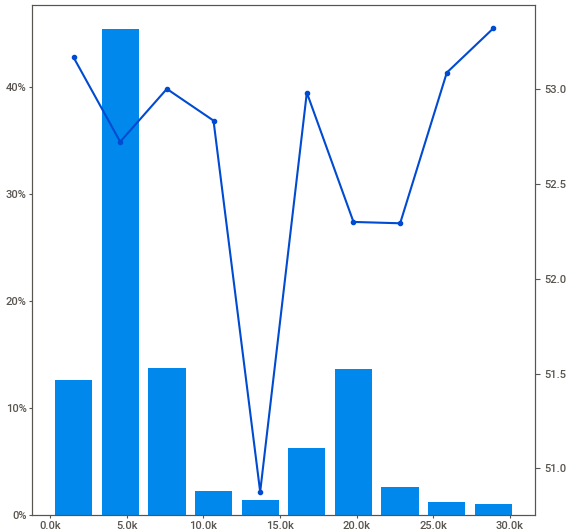
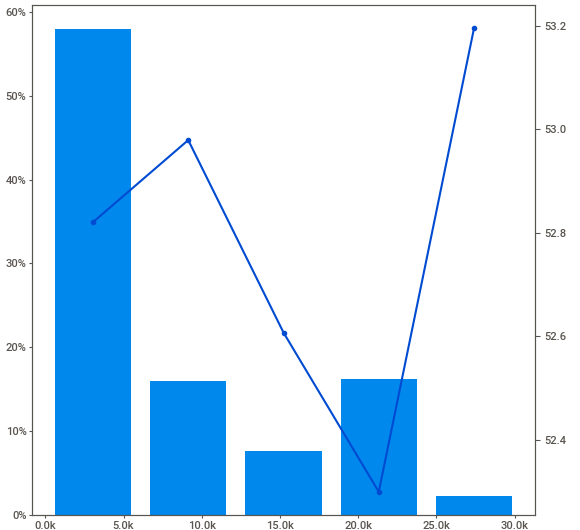
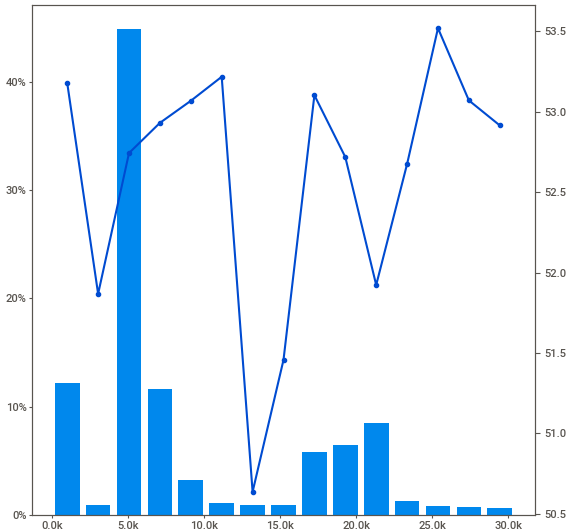
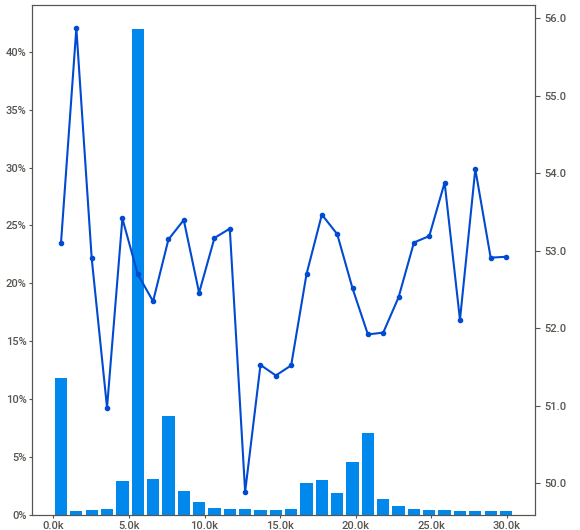
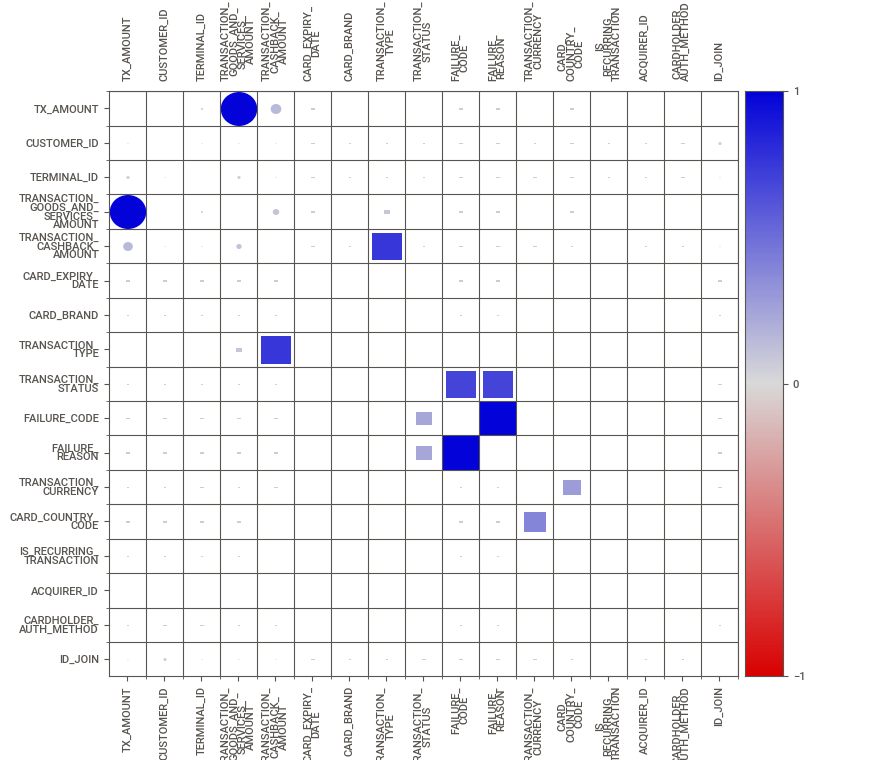
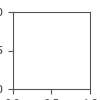

In [7]:
dataset_report = sw.analyze(transactions_train_df, "TX_AMOUNT")
dataset_report.show_notebook(layout='vertical')